In [13]:
import os
os.environ['JAX_ENABLE_X64'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.2' 

%matplotlib widget
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from temgym_core.ray import Ray
from temgym_core.source import ParallelBeam
from temgym_core.components import Detector, Lens, Deflector, Plane
from temgym_core.gaussian import GaussianRay, evaluate_gaussian_input_image, make_gaussian_image
from temgym_core.utils import fibonacci_spiral, FresnelPropagator
import numpy as np

from __future__ import annotations
import numpy as np
from skimage.restoration import unwrap_phase

from temgym_core.run import run_to_end, run_iter
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)
import jax_dataclasses as jdc

In [14]:
import jax
import jax.numpy as jnp
import jax_dataclasses as jdc

# ---------- Core types (same as before) ----------

@jdc.pytree_dataclass
class Ray:
    x: float; y: float; dx: float; dy: float; z: float
    pathlength: float = 0.0
    _one: float = 1.0
    def derive(self, **kw): return jdc.replace(self, **kw)
    def r_xy(self): return jnp.array([self.x, self.y])
    def d_xy(self): return jnp.array([self.dx, self.dy])

@jdc.pytree_dataclass
class GaussianPacket:
    center: Ray
    theta: jnp.ndarray         # (2,) complex
    Q_inv: jnp.ndarray         # (2,2) complex
    C: complex
    k0: float
    def derive(self, **kw): return jdc.replace(self, **kw)

def apply_thin_element_local(
    gp: GaussianPacket,
    phi0: float, g_phi: jnp.ndarray, H_phi: jnp.ndarray,
    ell0: float = 0.0, g_ell: jnp.ndarray = None, H_ell: jnp.ndarray = None
) -> GaussianPacket:
    """C' = C e^{ell0} e^{i k phi0}; theta' = theta - g_phi + i/k g_ell; Qinv' = Qinv - H_phi + i/k H_ell
       Also update geometric direction with +g_phi (phase kick)."""
    k = gp.k0
    if g_ell is None: g_ell = jnp.zeros((2,))
    if H_ell is None: H_ell = jnp.zeros((2,2))
    # Symmetrize for numerical cleanliness
    H_phi = 0.5*(H_phi + H_phi.T)
    H_ell = 0.5*(H_ell + H_ell.T)

    C_out     = gp.C * jnp.exp(ell0) * jnp.exp(1j*k*phi0)
    theta_out = gp.theta - g_phi + (1j/k)*g_ell
    Qinv_out  = gp.Q_inv - H_phi + (1j/k)*H_ell

    dxy = gp.center.d_xy() + g_phi
    center_out = gp.center.derive(dx=float(dxy[0]), dy=float(dxy[1]))
    return gp.derive(center=center_out, theta=theta_out, Q_inv=Qinv_out, C=C_out)

# ---------- Base class: thin phase element (override only OPL) ----------

@jdc.pytree_dataclass
class ThinPhaseElement:
    """Base for any thin *phase* element."""
    z: float

    # --- Override in subclasses ---
    def opl(self, r_xy: jnp.ndarray) -> float:
        raise NotImplementedError

    def grad_hess_opl(self, r_xy: jnp.ndarray):
        phi = lambda rr: self.opl(rr)
        g = jax.grad(phi)(r_xy)         # (2,)
        H = jax.hessian(phi)(r_xy)      # (2,2)
        return g, H

    # --- Geometric ray kick (phase gradient) ---
    def __call__(self, ray: Ray) -> Ray:
        r = ray.r_xy()
        g_phi, _ = self.grad_hess_opl(r)
        return ray.derive(dx=float(ray.dx + g_phi[0]),
                          dy=float(ray.dy + g_phi[1]),
                          z=self.z)

    # --- Gaussian packet update (phase-only) ---
    def gaussian_update(self, gp: GaussianPacket) -> GaussianPacket:
        r = gp.center.r_xy()
        g_phi, H_phi = self.grad_hess_opl(r)
        phi0 = self.opl(r)
        return apply_thin_element_local(
            gp,
            phi0=phi0, g_phi=g_phi, H_phi=H_phi,
            ell0=0.0, g_ell=jnp.zeros(2), H_ell=jnp.zeros((2,2))
        )

# ---------- Subclasses: only the OPL differs ----------

@jdc.pytree_dataclass
class Lens(ThinPhaseElement):
    focal_length: float

    def opl(self, r_xy: jnp.ndarray) -> float:
        # δφ = -(x^2 + y^2)/(2 f)
        x, y = r_xy[0], r_xy[1]
        return -0.5 * (x*x + y*y) / self.focal_length


@jdc.pytree_dataclass
class AberratedLens(ThinPhaseElement):
    focal_length: float
    C_sph: float = 0.0        # spherical aberration coefficient
    C_coma_x: float = 0.0     # coma along x
    C_coma_y: float = 0.0     # coma along y

    def opl(self, r_xy: jnp.ndarray) -> float:
        x, y = r_xy[0], r_xy[1]
        rho2 = x*x + y*y
        phi_lens = -0.5 * rho2 / self.focal_length
        phi_sph  = self.C_sph * (rho2 * rho2)                  # (x^2+y^2)^2
        phi_coma = self.C_coma_x * (x**3 + x*y**2) \
                 + self.C_coma_y * (y**3 + y*x**2)             # Seidel coma (Cartesian)
        return phi_lens + phi_sph + phi_coma


In [15]:
import jax
import jax.numpy as jnp
import jax_dataclasses as jdc

# --- dataclasses from earlier message (Ray, GaussianPacket, Lens, apply_thin_element_local) assumed available ---

# constants
lam = 0.0025  # wavelength in same units as x,y (example)
k0  = 2*jnp.pi/lam
w0  = 10.0    # waist radius (same units)
x0, y0 = 5.0, -3.0  # beam center offset
f   = 100.0  # focal length

# initial geometric ray at lens plane
ray0 = Ray(x=float(x0), y=float(y0), dx=0.0, dy=0.0, z=0.0)

# initial Gaussian params: plane-phase Gaussian with waist w0, centered at (x0,y0)
Qinv_in = -1j * (2.0/(k0*w0**2)) * jnp.eye(2)  # infinite ROC (purely imag)
theta_in = jnp.array([0.0+0.0j, 0.0+0.0j])     # no tilt at center
C_in = 1.0 + 0.0j

gp_in = GaussianPacket(center=ray0, theta=theta_in, Q_inv=Qinv_in, C=C_in, k0=float(k0))

# define the lens
lens = Lens(z=0.0, focal_length=f)

# compute local phase derivatives at the center
r = gp_in.center.r_xy()
g_phi = jax.grad(lens.opl)(r)             # = -(1/f) * r
H_phi = jax.hessian(lens.opl)(r)          # = -(1/f) * I
phi0  = lens.opl(r)

# apply thin phase update (ell terms = 0)
gp_out = apply_thin_element_local(
    gp_in, phi0=phi0, g_phi=g_phi, H_phi=H_phi,
    ell0=0.0, g_ell=jnp.zeros(2), H_ell=jnp.zeros((2,2))
)

# gp_out now has:
#   gp_out.theta   = (1/f) * [x0, y0]   (real)
#   gp_out.Q_inv   = Qinv_in + (1/f) * I
#   gp_out.C       = C_in * exp(i k0 * phi0)
#   gp_out.center.dx,dy = -(1/f)*[x0,y0]

print("gp_out.theta:", gp_out.theta)
print("gp_out.Q_inv:", gp_out.Q_inv)
print("gp_out.C:", gp_out.C)
print("gp_out.center.dx:", gp_out.center.dx)
print("gp_out.center.dy:", gp_out.center.dy)


gp_out.theta: [ 0.05+0.j -0.03+0.j]
gp_out.Q_inv: [[0.01-7.95774715e-06j 0.  +0.00000000e+00j]
 [0.  +0.00000000e+00j 0.01-7.95774715e-06j]]
gp_out.C: (1-1.1766512962000004e-14j)
gp_out.center.dx: -0.05
gp_out.center.dy: 0.03


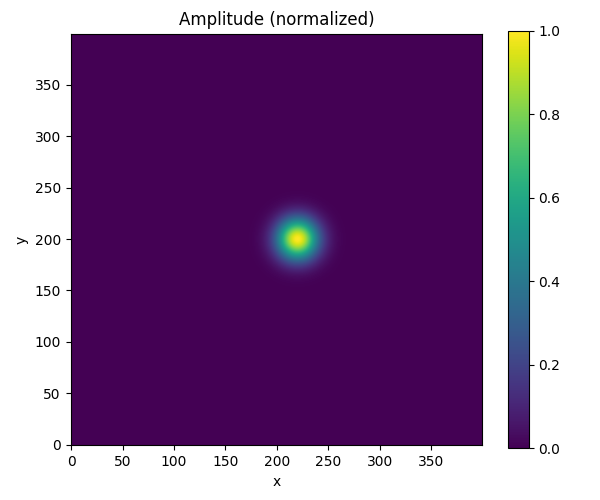

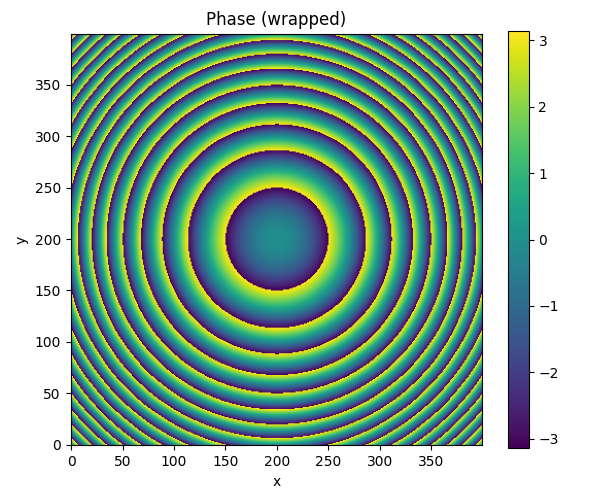

In [16]:
# Evaluate and visualize the amplitude and phase of the example Gaussian after a thin lens.
import numpy as np
import matplotlib.pyplot as plt

# Parameters (units arbitrary but consistent)
lam = 0.25  # wavelength
k0  = 2*np.pi/lam
w0  = 2
x0, y0 = 2, 0.0  # beam center offset
f   = 100.0  # focal length

# Gaussian parameters before lens (plane-phase Gaussian with waist w0 at center r0)
Qinv_in = -1j * (2.0/(k0*w0**2)) * np.eye(2)  # purely imaginary (infinite ROC)
theta_in = np.array([0.0+0.0j, 0.0+0.0j])     # no tilt at the center
C_in = 1.0 + 0.0j
r0 = np.array([x0, y0])

# Lens thin-element parameters at the center r0
# phase OPL: delta phi = -(x^2+y^2)/(2f)
phi0 = - (x0**2 + y0**2) / (2.0 * f)
g_phi = - (1.0/f) * r0
H_phi = - (1.0/f) * np.eye(2)

# Apply thin-element update (phase-only; ell terms = 0)
theta_out = theta_in - g_phi              # = (1/f)*r0 (real)
Qinv_out  = Qinv_in - H_phi               # = Qinv_in + (1/f) I
C_out     = C_in * np.exp(1j * k0 * phi0) # scalar phase factor

# Make an evaluation grid around the beam center (local model best near r0)
W = 40
Nx = Ny = 400
x = np.linspace(-W/2, W/2, Nx)
y = np.linspace(-W/2, W/2, Ny)
X, Y = np.meshgrid(x, y, indexing='xy')
dX = X - x0
dY = Y - y0
dR = np.stack([dX, dY], axis=-1)  # (...,2)

# Evaluate the local Gaussian field:
# E(r) = C * exp( -i k [ theta^T Δr + 1/2 Δr^T Qinv Δr ] )
# Compute quadratic form efficiently
Q = Qinv_out
lin = theta_out[0]*dX + theta_out[1]*dY  # complex linear term
# quadratic form Δr^T Q Δr
quad = (Q[0,0]*(dX**2) + (Q[0,1]+Q[1,0])*(0.5*dX*dY) + Q[1,1]*(dY**2))  # ensure symmetric use

E = C_out * np.exp(-1j * k0 * (lin + 0.5*quad))

amp = np.abs(E)
phase = np.angle(E)

# Normalize amplitude for visualization
amp_norm = amp / amp.max()

# Plot amplitude
plt.figure(figsize=(6,5))
plt.imshow(amp_norm, origin='lower', aspect='equal')
plt.title('Amplitude (normalized)')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.tight_layout()
plt.show()

# Plot phase
plt.figure(figsize=(6,5))
plt.imshow(phase, origin='lower', aspect='equal')
plt.title('Phase (wrapped)')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.tight_layout()
plt.show()



In [17]:
lam = 0.25
k0  = 2*np.pi/lam
w0  = 4
x0, y0 = 5., 5.
f   = 100.0
C_sph   = 1.0e-6
C_coma_x = 1e-5
C_coma_y = 2e-4

ray0 = Ray(x=x0, y=y0, dx=0.0, dy=0.0, z=0.0)
Qinv0 = -1j * (2.0/(k0*w0**2)) * np.eye(2)
theta0 = np.array([0.0+0.0j, 0.0+0.0j])
C0 = 1.0 + 0.0j
gp0 = GaussianPacket(center=ray0, theta=theta0, Q_inv=Qinv0, C=C0, k0=k0)

# -------------------- Apply the component to update the Gaussian --------------------
lens = AberratedLens(z=0.0, focal_length=f, C_sph=C_sph, C_coma_x=C_coma_x, C_coma_y=C_coma_y)
gp1  = lens.gaussian_update(gp0)   # <-- uses the component path

# -------------------- Evaluate fields on a grid --------------------
W = 60
Nx = Ny = 500
x = np.linspace(- W/2,  W/2, Nx)
y = np.linspace(- W/2,  W/2, Ny)
X, Y = np.meshgrid(x, y, indexing='xy')


# Exact field (analytic phase OPL from the component) times input Gaussian envelope
phi_exact = lens.opl(np.stack([X, Y], axis=0))  # vectorized by numpy broadcasting
E_in = np.exp(-((X - x0)**2 + (Y - y0)**2)/w0**2)
E_exact = np.exp(1j*gp1.k0*phi_exact) * E_in

# Local-Gaussian approximation after the component update
# Evaluate at (X-x0, Y-y0) so the Gaussian is centered at (x0, y0)
lin = gp1.theta[0]*(X - x0) + gp1.theta[1]*(Y - y0)
Q = gp1.Q_inv
quad = (Q[0,0]*((X - x0)**2) + (Q[0,1]+Q[1,0])*(0.5*(X - x0)*(Y - y0)) + Q[1,1]*((Y - y0)**2))
E_local = gp1.C * np.exp(-1j*gp1.k0*(lin + 0.5*quad))

amp_exact = np.abs(E_exact); amp_exact /= amp_exact.max()
phase_exact = np.angle(E_exact)
phase_local = np.angle(E_local)
phase_diff = np.angle(np.exp(1j*(np.abs(phase_exact) - np.abs(phase_local))))
phase_exact_unwrapped = unwrap_phase(phase_exact)
phase_local_unwrapped = unwrap_phase(phase_local)
phase_unwrapped_diff = np.abs(phase_exact_unwrapped) - np.abs(phase_local_unwrapped)

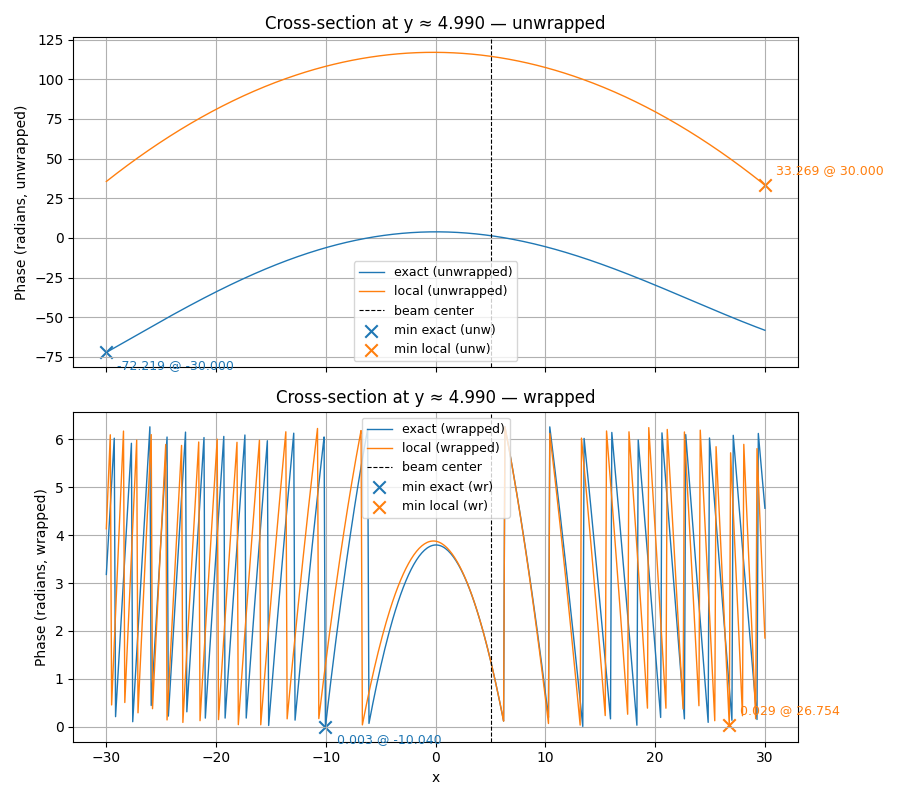

In [18]:
# extract x cross-section at y ≈ y0
idx_y = np.argmin(np.abs(y - y0))

# unwrapped cross-sections (existing)
ps_x_exact = phase_exact_unwrapped[idx_y, :].copy()
ps_x_local = phase_local_unwrapped[idx_y, :].copy()

# wrapped cross-sections (new)
ps_x_exact_wrapped = np.mod(phase_exact[idx_y, :].copy(), 2 * np.pi)
ps_x_local_wrapped = np.mod(phase_local[idx_y, :].copy(), 2 * np.pi)

# minima indices
ix_min_exact_unw = int(np.argmin(ps_x_exact))
ix_min_local_unw = int(np.argmin(ps_x_local))
ix_min_exact_wr = int(np.argmin(ps_x_exact_wrapped))
ix_min_local_wr = int(np.argmin(ps_x_local_wrapped))

fig, axes = plt.subplots(2, 1, figsize=(9, 8), sharex=True)

# Top: unwrapped
ax = axes[0]
ax.plot(x, ps_x_exact, label='exact (unwrapped)', color='C0', lw=1)
ax.plot(x, ps_x_local, label='local (unwrapped)', color='C1', lw=1)
ax.axvline(x0, color='k', ls='--', lw=0.8, label='beam center')
ax.scatter([x[ix_min_exact_unw]], [ps_x_exact[ix_min_exact_unw]], color='C0', marker='x', s=80, label='min exact (unw)')
ax.scatter([x[ix_min_local_unw]], [ps_x_local[ix_min_local_unw]], color='C1', marker='x', s=80, label='min local (unw)')
ax.annotate(f"{ps_x_exact[ix_min_exact_unw]:.3f} @ {x[ix_min_exact_unw]:.3f}",
            xy=(x[ix_min_exact_unw], ps_x_exact[ix_min_exact_unw]),
            xytext=(8, -12), textcoords='offset points', color='C0', fontsize=9)
ax.annotate(f"{ps_x_local[ix_min_local_unw]:.3f} @ {x[ix_min_local_unw]:.3f}",
            xy=(x[ix_min_local_unw], ps_x_local[ix_min_local_unw]),
            xytext=(8, 8), textcoords='offset points', color='C1', fontsize=9)
ax.set_ylabel('Phase (radians, unwrapped)')
ax.set_title(f'Cross-section at y ≈ {y[idx_y]:.3f} — unwrapped')
ax.grid(True)
ax.legend(loc='best', fontsize=9)

# Bottom: wrapped
ax = axes[1]
ax.plot(x, ps_x_exact_wrapped, label='exact (wrapped)', color='C0', lw=1)
ax.plot(x, ps_x_local_wrapped, label='local (wrapped)', color='C1', lw=1)
ax.axvline(x0, color='k', ls='--', lw=0.8, label='beam center')
ax.scatter([x[ix_min_exact_wr]], [ps_x_exact_wrapped[ix_min_exact_wr]], color='C0', marker='x', s=80, label='min exact (wr)')
ax.scatter([x[ix_min_local_wr]], [ps_x_local_wrapped[ix_min_local_wr]], color='C1', marker='x', s=80, label='min local (wr)')
ax.annotate(f"{ps_x_exact_wrapped[ix_min_exact_wr]:.3f} @ {x[ix_min_exact_wr]:.3f}",
            xy=(x[ix_min_exact_wr], ps_x_exact_wrapped[ix_min_exact_wr]),
            xytext=(8, -12), textcoords='offset points', color='C0', fontsize=9)
ax.annotate(f"{ps_x_local_wrapped[ix_min_local_wr]:.3f} @ {x[ix_min_local_wr]:.3f}",
            xy=(x[ix_min_local_wr], ps_x_local_wrapped[ix_min_local_wr]),
            xytext=(8, 8), textcoords='offset points', color='C1', fontsize=9)
ax.set_xlabel('x')
ax.set_ylabel('Phase (radians, wrapped)')
ax.set_title(f'Cross-section at y ≈ {y[idx_y]:.3f} — wrapped')
ax.grid(True)
ax.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.show()

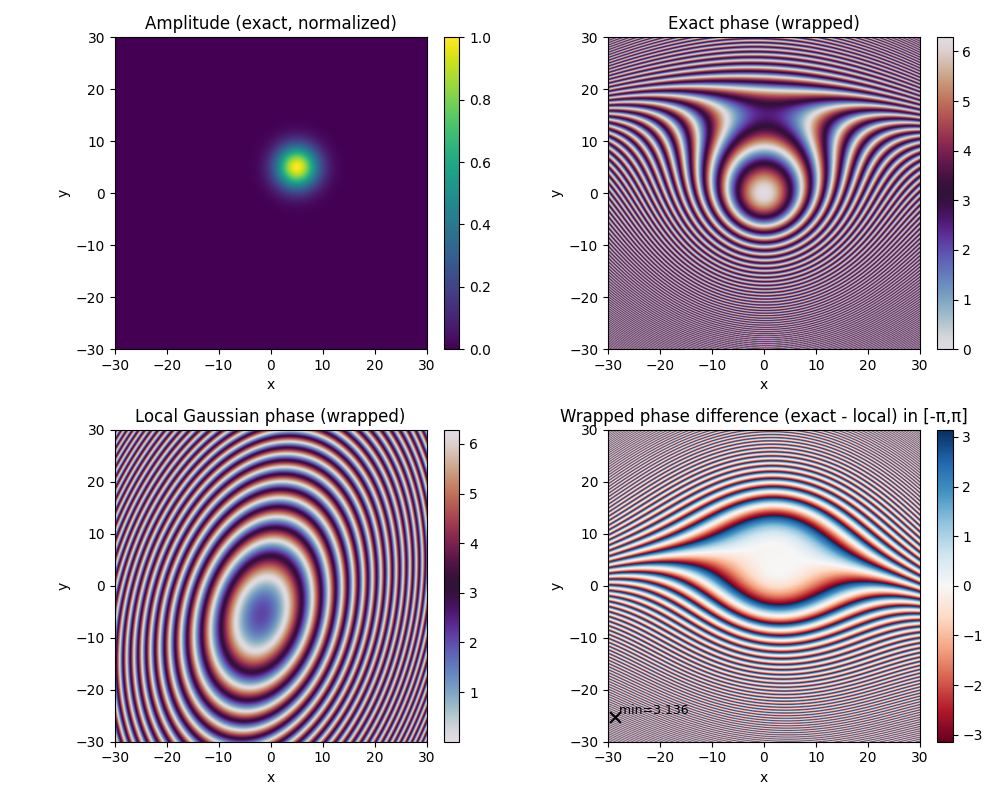

In [20]:
# Simplified "modulo" plots: amplitude + wrapped phases + wrapped phase difference (centered)
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
extent = [x.min(), x.max(), y.min(), y.max()]

# Amplitude (exact, normalized)
amp_exact_norm = amp_exact / amp_exact.max()
im0 = ax[0, 0].imshow(amp_exact_norm, origin='lower', aspect='equal', extent=extent)
ax[0, 0].set_title('Amplitude (exact, normalized)')
ax[0, 0].set_xlabel('x'); ax[0, 0].set_ylabel('y')
fig.colorbar(im0, ax=ax[0, 0], fraction=0.046, pad=0.04)

# Exact phase (wrapped to [0, 2π))
phase_exact_wrapped = np.mod(phase_exact, 2*np.pi)
im1 = ax[0, 1].imshow(phase_exact_wrapped, origin='lower', aspect='equal', extent=extent, cmap='twilight')
ax[0, 1].set_title('Exact phase (wrapped)')
ax[0, 1].set_xlabel('x'); ax[0, 1].set_ylabel('y')
fig.colorbar(im1, ax=ax[0, 1], fraction=0.046, pad=0.04)

# Local Gaussian phase (wrapped to [0, 2π))
phase_local_wrapped = np.mod(phase_local, 2*np.pi)
im2 = ax[1, 0].imshow(phase_local_wrapped, origin='lower', aspect='equal', extent=extent, cmap='twilight')
ax[1, 0].set_title('Local Gaussian phase (wrapped)')
ax[1, 0].set_xlabel('x'); ax[1, 0].set_ylabel('y')
fig.colorbar(im2, ax=ax[1, 0], fraction=0.046, pad=0.04)

# Wrapped phase difference (centered in [-π, π])
phase_diff_wrapped_centered = np.angle(np.exp(1j * (phase_exact - phase_local)))
im3 = ax[1, 1].imshow(phase_diff_wrapped_centered, origin='lower', aspect='equal', extent=extent, cmap='RdBu')
ax[1, 1].set_title('Wrapped phase difference (exact - local) in [-π,π]')
ax[1, 1].set_xlabel('x'); ax[1, 1].set_ylabel('y')
fig.colorbar(im3, ax=ax[1, 1], fraction=0.046, pad=0.04)

# Mark minima on the wrapped-difference plot (use computed minima if available)
try:
    xi, yi = min_idx_wrapped[1], min_idx_wrapped[0]
    x_min_wrapped = x[xi]; y_min_wrapped = y[yi]
    min_val_wrapped = float(phase_diff_wrapped_centered[yi, xi])
    ax[1, 1].scatter(x_min_wrapped, y_min_wrapped, s=60, c='k', marker='x')
    ax[1, 1].text(x_min_wrapped, y_min_wrapped, f' min={min_val_wrapped:.3f}', color='k', fontsize=9,
                  verticalalignment='bottom', horizontalalignment='left')
except Exception:
    pass

plt.tight_layout()
plt.show()
